In [1]:
import json
import os
import pickle
from collections import defaultdict
from glob import glob
from pathlib import Path
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem

from plot_utils import *
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import copy
import re 
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import PercentFormatter
from utils import *

params = {
    'font.size': 18,
    'legend.fontsize': 18,
    'text.usetex': False,
}
rcParams.update(params)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import warnings
warnings.filterwarnings('ignore')

In [3]:
def fit_clfs(df, is_aldh1=False, topliss_augmented=False):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints

    
    if is_aldh1:
        df = pd.read_csv("210415_LIT_PCBA_ALDH1_Best_AB_sets.csv")
        in_set_A = np.where(df['in_set_A']==1)[0]
        in_set_B = np.where(df['in_set_B']==1)[0]
        smiles = df["SMILES"]
        activity = df["Act"]
        index_test = []
        for i in range(len(smiles)):
            if i not in in_set_A and i not in in_set_B:
                index_test.append(i)

        in_test = np.array(index_test)

        #in_test = np.where(df['in_set_A']==0 and df['in_set_B']==0)


        X1 = np.array(ecfp(smiles[in_set_A]))
        X2 = np.array(ecfp(smiles[in_set_B]))

        y1 = np.array(activity[in_set_A])
        y2 = np.array(activity[in_set_B])
        smiles_test = np.array(smiles)[in_test]
    else:
        df['ecfp'] = ecfp(df.smiles)
        df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=0)


        df1, df2 = train_test_split(df_train, test_size=0.5, stratify=df_train['label'], random_state=0)
        X1 = np.array(list(df1['ecfp']))
        X2 = np.array(list(df2['ecfp']))

        y1 = np.array(list(df1['label']))
        y2 = np.array(list(df2['label']))

        del df1['ecfp']
        del df2['ecfp']
        smiles_test = df_test.smiles
    
    
    balance = (np.mean(y1), np.mean(y2))
    clf_1 = RandomForestClassifier(
        n_estimators=100, random_state=0, min_samples_leaf=1, max_depth=None)

    clf_2 = RandomForestClassifier(
        n_estimators=100, random_state=0)
    clf_1.fit(X1, y1)
    clf_2.fit(X2, y2)
    test_scores = clf_1.predict_proba(ecfp(smiles_test))[:, 1]
    
    if topliss_augmented:
        augmented_smiles_test = []
        for i, s in enumerate(smiles_test):
            if test_scores[i]>0.25:
                augmented_smiles_test.extend(topliss_walk(s, n_combinations=2))
            else:
                augmented_smiles_test.extend([s])
        augmented_smiles_test = np.array(augmented_smiles_test)
        X_test = ecfp(augmented_smiles_test)
    else:
        augmented_smiles_test = smiles_test
        X_test = ecfp(augmented_smiles_test)

    scores_1 = clf_1.predict_proba(X_test)[:, 1]
    scores_2 = clf_2.predict_proba(X_test)[:, 1]

    return df1.smiles, df2.smiles, y1, y2, augmented_smiles_test, scores_1, scores_2

def get_sims(smiles_1, smiles_2):
    neigh = NearestNeighbors(10, 0.1, metric='jaccard', algorithm='brute')
    neigh.fit(ecfp(smiles_2))
    sims = []
    for x in ecfp(smiles_1):
        dist, idx = neigh.kneighbors(x.reshape(1, -1))
        sims.extend(dist[0])
    return sims

# Similarity of high scoring molecules in held-out test set with Split 1/2 molecules

In [2]:
columns = ['AssayID', 'TargetName', 'TargetID']

rows = [('CHEMBL3888429', 'JAK2', 'CHEMBL2971'),
        ('CHEMBL1909203', 'EGFR', 'CHEMBL203'),
        ('CHEMBL1909140', 'DRD2', 'CHEMBL217'),
        ('CHEMBL1794345', 'Pla. Fal.', 'CHEMBL364'),
        ('CHEMBL1741322', 'Cytochrome', 'CHEMBL3356'),
        ('CHEMBL1963961', 'CCRF-CEM', 'CHEMBL382')]

assay_info = pd.DataFrame(rows, columns=columns)

chid2name = dict(zip(assay_info['AssayID'], assay_info['TargetName']))


chids = ['CHEMBL3888429', 'CHEMBL1909203', 'CHEMBL1909140']
optimizers = ['graph_ga', 'lstm_hc', 'mso']
auc_title = False # whether or not to include auc in plot
lw = 0.7 # line width
nrows = 1 # for two optimizers
ncols = len(chids) # for the number of tasks

0.5913809523809523
0.48
0.68


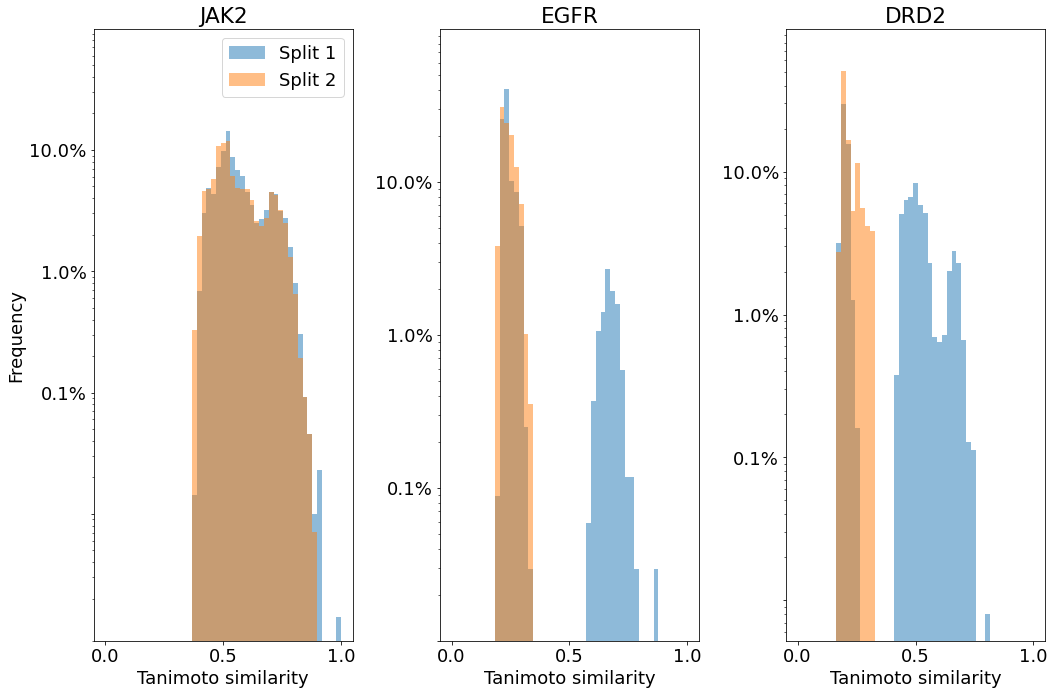

In [27]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 10*nrows), sharex=True)
for c_idx, chid in enumerate(chids):
    ax = axes[c_idx]
    assay_file ='assays/processed/' + str(chid) + '.csv'
    df = pd.read_csv(assay_file)    
    smiles_1, smiles_2, y1, y2, smiles_test, scores_1, scores_2 = fit_clfs(df, topliss_augmented=True)
    top_percentile = np.percentile(scores_1, 95)
    similarities_1 = get_sims(np.array(smiles_test)[np.where(scores_1>top_percentile)[0]], np.array(smiles_1))
    similarities_2 = get_sims(np.array(smiles_test)[np.where(scores_1>top_percentile)[0]], np.array(smiles_2))        
    alpha=0.5
    bins = np.linspace(0,1,50)
    ax.hist([1-x for x in similarities_1], bins=bins, alpha=alpha, label='Split 1', weights=np.ones(len(similarities_1)) / len(similarities_1), log=True)
    ax.hist([1-x for x in similarities_2], bins=bins, alpha=alpha, label='Split 2', weights=np.ones(len(similarities_2)) / len(similarities_2), log=True)
    ax.set_yscale('log')
    
    
    ax.set_title(chid2name[chid])
    low, high = ax.set_ylim(0, 1)
    ax.set_yticks([0.0001, 0.001, 0.01, 0.1])
    ax.set_yticklabels(["", "0.1%", "1.0%", "10.0%"])
    
    ax.set_title(chid2name[chid])


axes[0].legend()

axes[0].set_ylabel('Frequency')
    
for i in range(ncols):
    axes[i].set_xlabel('Tanimoto similarity')

xtext = -0.4
plt.tight_layout()
plt.savefig('figures/similarities_top_5.pdf', bbox_inches='tight')